In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import cmasher as cmr

import astropy.units as u
import astropy.constants as c

import scipy.interpolate as sint
import scipy.special as sspec
import scipy.stats as sstats

from multiprocess import Pool
from functools import partial
import tqdm
import pandas as pd

nproc = 8


## Load Data
The data here come from the Herschel Gould Belt Survey (Andre+2010). In particular, this notebook is for the example for the Taurus L1495 region. The data come from http://www.herschel.fr/cea/gouldbelt/en/Phocea/Vie_des_labos/Ast/ast_visu.php?id_ast=66. You can download using
```
wget http://www.herschel.fr/Images/astImg/66/HGBS_taurus_L1495_column_density_map.fits.gz
```
and put it into a local data directly (here assumed to be `./data/`).

To allow for computation on laptops and better compare to the results from the recent fantastic [DDPM work](https://ui.adsabs.harvard.edu/abs/2023ApJ...950..146X/abstract) of [Duo Xu](https://sites.google.com/view/xuduo), we load a downsampled version of the data. The data was generated using the following commands:

```python
from astropy.io import fits
from skimage.transform import downscale_local_mean
import scipy.ndimage as ndimage

fitFile = "data/HGBS_taurus_L1495_column_density_map.fits"
df = fits.open(fitFile)
colData = df[0].data

rotate_img = ndimage.rotate(colData,38)[4100:7300, 2100:8900]
rotate_img[rotate_img <= 1] = 0.0
dataDown = downscale_local_mean(rotate_img, (24,24))
np.save("data/taurus_lowRes.npy", dataDown)
```

In [2]:
cloudName = "taurus"
dataFile = "data/taurus_lowRes.npy"
dataZoom = np.load(dataFile)
colDataFlattened = dataZoom[dataZoom > 1E19].flatten()

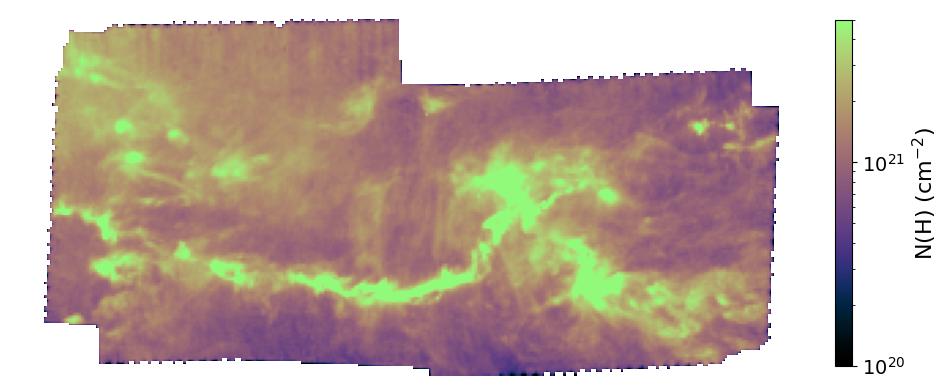

In [3]:
dataZoom_pl = dataZoom.copy()
dataZoom_pl[dataZoom_pl < 1E19] = np.nan

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

im1 = ax.imshow(dataZoom_pl, cmap=cmr.lilac, norm=colors.LogNorm(vmin=1e20, vmax=5e21), origin='lower')
ax.axis(False)
ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label("N(H) (cm$^{-2}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

In [4]:
N0 = 0.75*np.mean(colDataFlattened) 
stdFit = 0.35

Nspace = np.logspace(19, 22.5, 128) 
xspace = Nspace/N0
zetaSpace = np.log(xspace)

x = colDataFlattened/N0
zeta = np.log(x)
stdGuess = np.std(zeta)

histZeta, bin_edges = np.histogram(zeta, bins='auto', density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

histZetaLR, bin_edgesLR = np.histogram(zeta, bins=np.linspace(-2.5,2.5,48), density=True)
bin_centersLR = (bin_edgesLR[:-1] + bin_edgesLR[1:])/2

In [5]:
def lognormal(x, sigma):
    return np.exp(-0.5*(x/sigma)**2)/(sigma*np.sqrt(2*np.pi))

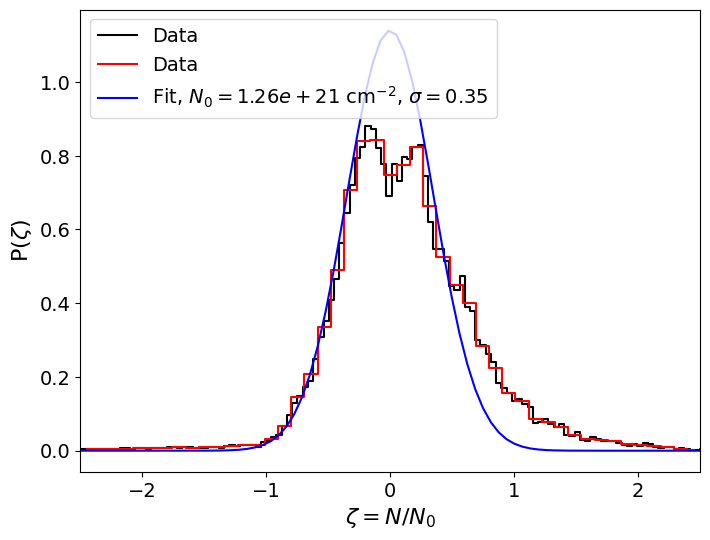

In [6]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.step(bin_centers, histZeta, where='mid', color='k', label='Data')
ax.step(bin_centersLR, histZetaLR, where='mid', color='r', label='Data')
ax.plot(zetaSpace, lognormal(zetaSpace, stdFit), 'b-', label='Fit, $N_0 = %.2e$ cm$^{-2}$, $\sigma = %.2f$'%(N0, stdFit))
ax.set_xlabel(r"$\zeta = N/N_0$",fontsize=16)
ax.set_ylabel("P($\zeta$)", fontsize=16)
ax.legend(loc=2, fontsize=14)
ax.set_xlim(-2.5,2.5)
ax.tick_params(which='both', axis='both', labelsize=14)
plt.show()

### Define the cloud macroscopic properties
We use typical cold cloud sizes and the results from the N-PDF fitting for the Mach number following the GMC clouds from Burkhart & Lazarian (2012). The cloud thicknesses should ideally come from newer Gaia results - we use 1 pc which is roughly consistent with the results from Qian+2015 and the newer 3D constraints from Zucker+2021. Using these, compute the transition density between the sonic scale and Jean's length.

In [7]:
Ms = np.sqrt((np.exp(stdFit**2 / (0.16)) - 1.)/(0.5)**2)
T = 15.0 * u.K
N0u = N0 * u.cm**-2
L = 1.0*u.pc


mu = 1.4
cs = np.sqrt(c.k_B*T/(mu*c.m_p))
sigma_Turb = stdFit
sigma_vel = Ms*cs

rhoJ = (np.pi*cs**2*Ms**4)/(c.G * L**2) #From Burkhart & Mocz 2019
nJ = rhoJ/(mu*c.m_p)
nJ = nJ.decompose().to(u.cm**(-3)) 

print(Ms, T, sigma_Turb, sigma_vel.decompose().to(u.km/u.s), nJ)

2.1450761440585735 15.0 K 0.35 0.6379212562329233 km / s 39530.90992628264 1 / cm3


In [8]:
dataDims = dataZoom.shape
nbinRes = 'auto' #64
dataZoom[np.isnan(dataZoom)] = 0.0

### Calculating the turbulent column density


In [9]:
Nsamp = int(1E4)

Ndata = dataDims[0]*dataDims[1]
modelITurbCol = np.zeros(dataDims)
modelIITurbCol = np.zeros(dataDims)

def turb_dens_col_func(k):
    dataDims = dataZoom.shape
    i = k // dataDims[1]
    j = k % dataDims[1]
    Nobs = dataZoom[i,j]
    if np.isnan(dataZoom[i,j]):
        print("NAN DATA")
    if Nobs <= 0:
        return None, None
    zetaMax = np.log(Nobs/N0)
    minspace = min(np.log(0.01*Nobs/N0), -20*sigma_Turb)

    a, b = minspace / sigma_Turb, zetaMax / sigma_Turb
    try:
        r = sstats.truncnorm.rvs(a, b, loc=0.0, scale=sigma_Turb, size=Nsamp)
    except ValueError:
        print(Nobs, N0, sigma_Turb, a, b)
    NT_obs = (N0*np.exp(r))

    hist, bin_edges = np.histogram(np.log10(NT_obs), bins=nbinRes, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

    atc = 10**(bin_centers[np.argmax(hist)])

    return atc, np.amax(NT_obs)

with Pool(processes=nproc) as p:
    batno = 0
    numBatch = 10
    nBatch = Ndata // numBatch
    k = 0
    while batno < numBatch:
        lower = batno*nBatch
        upper = (batno+1)*nBatch
        if batno == numBatch-1:
            upper = Ndata
        results = list(
            tqdm.tqdm(
                p.imap(turb_dens_col_func,
                    np.arange(lower, upper, 1), dataDims[1]),
                total=(upper - lower)
            )
        ) 
        for atci, matci in results:
            if atci is None:
                k += 1
                continue
            i = k // dataDims[1]
            j = k % dataDims[1]
            modelITurbCol[i,j] = atci
            modelIITurbCol[i,j] = matci
            k += 1
        del results
        batno += 1
    p.close()
    p.join()

100%|██████████| 3811/3811 [00:00<00:00, 12021.94it/s]


In [10]:
n_range = np.logspace(-2, 9, 128) * u.cm**-3
x_range = n_range/nJ

y = x_range**(1.5)/(1 + x_range)
dN = y*(np.sqrt(np.pi/(c.G*mu*c.m_p))*cs*nJ**(1/2)).decompose().to(u.cm**-2)
dN_n_interp = sint.interp1d(dN.value, n_range.value, kind='linear', fill_value='extrapolate', bounds_error=False)

### Method I gravitational density

In [11]:
modelIGravDens = np.zeros(dataDims)
modelITurbDens = np.zeros(dataDims)

def modelIGravDens_func(k):
    i = k // dataDims[1]
    j = k % dataDims[1]
    if dataZoom[i,j] <= 0:
        return None, None
    atc = modelITurbCol[i,j]
    dNi = dataZoom[i,j] - atc
    if dNi <= 0:
        agd = 0.0
    else:
        agd = dN_n_interp(dNi)

    xi = agd/(nJ.value)
    switchi = xi/(1 + xi)
    lambdai = (np.sqrt((np.pi*cs**2)/(c.G*mu*c.m_p))*(agd*(u.cm**(-3)))**(-1/2)).decompose().to(u.pc)
    atd = atc/((L - switchi*lambdai).to(u.cm).value)

    return atd, agd

with Pool(processes=nproc) as p:
    batno = 0
    numBatch = 10
    nBatch = Ndata // numBatch
    k = 0
    while batno < numBatch:
        lower = batno*nBatch
        upper = (batno+1)*nBatch
        if batno == numBatch-1:
            upper = Ndata
        results = list(
            tqdm.tqdm(
                p.imap(modelIGravDens_func ,
                    np.arange(lower, upper, 1), dataDims[1]),
                total=(upper - lower)
            )
        ) 
        for atd, agd in results:
            if atd is None:
                k += 1
                continue
            i = k // dataDims[1]
            j = k % dataDims[1]
            modelITurbDens[i,j] = atd
            modelIGravDens[i,j] = agd
            k += 1
        del results
        batno += 1
    p.close()
    p.join()

100%|██████████| 3811/3811 [00:00<00:00, 437045.24it/s]


In [12]:
modelIIGravDens = np.zeros((dataDims[0], dataDims[1]))
modelIITurbDens = np.zeros((dataDims[0], dataDims[1]))

def sampGravDens_func(k):
    i = k // dataDims[1]
    j = k % dataDims[1]
    if dataZoom[i,j] <= 0:
        return None, None
    atc = modelIITurbCol[i,j]
    dNi = dataZoom[i,j] - atc
    if dNi <= 0:
        agd = 0.0
    else:
        agd = dN_n_interp(dNi)

    xi = agd/(nJ.value)
    if agd > 0:
        switchi = xi/(1 + xi)
        lambdai = (np.sqrt((np.pi*cs**2)/(c.G*mu*c.m_p))*(agd*(u.cm**(-3)))**(-1/2)).decompose().to(u.pc)
    else:
        switchi = 0.0
        lambdai = 0.0
    atd = atc/((L - switchi*lambdai).to(u.cm).value)

    if (atd < 0) or (agd < 0):
        print ("Error 1: ", i, j, dataZoom[i,j], atc, dNi, agd, switchi, lambdai, atd)
        import sys
        sys.exit()
    if ~np.isfinite(atd) or ~np.isfinite(switchi*lambdai) or (L - switchi*lambdai <= 0):
        print ("Error 2: ", i, j, dataZoom[i,j], atc, dNi, agd, switchi, lambdai, atd)
        import sys
        sys.exit()

    return atd, agd

with Pool(processes=nproc) as p:
    batno = 0
    numBatch = 10
    nBatch = Ndata // numBatch
    k = 0
    while batno < numBatch:
        lower = batno*nBatch
        upper = (batno+1)*nBatch
        if batno == numBatch-1:
            upper = Ndata
        results = list(
            tqdm.tqdm(
                p.imap(sampGravDens_func ,
                    np.arange(lower, upper, 1), dataDims[1]),
                total=(upper - lower)
            )
        ) 
        for atd, agd in results:
            if atd is None:
                k += 1
                continue
            i = k // dataDims[1]
            j = k % dataDims[1]
            modelIITurbDens[i,j] = atd
            modelIIGravDens[i,j] = agd
            k += 1
        del results
        batno += 1
    p.close()
    p.join()



100%|██████████| 3811/3811 [00:00<00:00, 4033432.39it/s]


### Method I - Gravitational Column Density

In [13]:
x_obs = modelIGravDens/(nJ.value)
switch_obs = x_obs/(1 + x_obs)

lambdaJ_map = (np.sqrt((np.pi*cs**2)/(c.G*mu*c.m_p))*(modelIGravDens*(u.cm**(-3)))**(-1/2)).decompose().to(u.pc)
lambdaJ_map[modelIGravDens <= 0] = 0.0*u.pc
modelIGravCol = modelIGravDens*switch_obs*lambdaJ_map.to(u.cm).value

/Users/brandt/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Method II - Gravitational Column Density

In [14]:
x_obs = modelIIGravDens/(nJ.value)
switch_obs = x_obs/(1 + x_obs)

lambdaJ_map = (np.sqrt((np.pi*cs**2)/(c.G*mu*c.m_p))*(modelIIGravDens*(u.cm**(-3)))**(-1/2)).decompose().to(u.pc)
lambdaJ_map[modelIIGravDens <= 0] = 0.0*u.pc
modelIIGravCol = modelIIGravDens*switch_obs*lambdaJ_map.to(u.cm).value


One of the fundamental parameters in astrochemical models is the column density that is attenuating an external ultraviolet radiation field. By geometrical considerations, this cannot be the observed column density since it is the integration through the entire cloud line of sight, rather than from a particular point out to the edge of the cloud. 

We can estimate this effective column density for the gas clump with density $n_J$ by inverting the model. We calculate here using both the Method I and the Method II for the turbulent column densities. However, instead of the turbulent column density tracing a line of sight through the cloud, it is from a random point along the line of sight to the edge of the cloud.

In [15]:
ModelI_Neff = np.zeros(dataDims)

def neff_func(k):
    dataDims = dataZoom.shape
    i = k // dataDims[1]
    j = k % dataDims[1]
    Nobs = dataZoom[i,j]
    if Nobs <= 0:
        return None
    zetaMax = np.log(Nobs/N0)
    minspace = min(np.log(0.01*Nobs/N0), -20*sigma_Turb)

    a, b = minspace / sigma_Turb, zetaMax / sigma_Turb
    try:
        r = sstats.truncnorm.rvs(a, b, loc=0.0, scale=sigma_Turb, size=Nsamp)
    except ValueError:
        print(Nobs, N0, sigma_Turb, a, b)
    randSpot = np.random.uniform(0, 1, Nsamp)
    NT_eff = 0.5*randSpot*(N0*np.exp(r))

    hist, bin_edges = np.histogram(np.log10(NT_eff), bins=nbinRes, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

    turbCol = 10**(bin_centers[np.argmax(hist)])

    neffi = turbCol + modelIGravCol[i,j]

    return neffi

with Pool(processes=nproc) as p:
    batno = 0
    numBatch = 10
    nBatch = Ndata // numBatch
    k = 0
    while batno < numBatch:
        lower = batno*nBatch
        upper = (batno+1)*nBatch
        if batno == numBatch-1:
            upper = Ndata
        results = list(
            tqdm.tqdm(
                p.imap(neff_func,
                    np.arange(lower, upper, 1), dataDims[1]),
                total=(upper - lower)
            )
        )
        for neffi in results:
            if neffi is None:
                k += 1
                continue
            i = k // dataDims[1]
            j = k % dataDims[1]
            ModelI_Neff[i,j] = neffi
            k += 1
        del results
        batno += 1
    p.close()
    p.join()

100%|██████████| 3811/3811 [00:00<00:00, 11093.51it/s]


In [16]:
ModelII_Neff = np.zeros(dataDims)

def neff_funcSamp(k):
    dataDims = dataZoom.shape
    i = k // dataDims[1]
    j = k % dataDims[1]
    Nobs = dataZoom[i,j]
    if Nobs <= 0:
        return None
    zetaMax = np.log(Nobs/N0)
    minspace = min(np.log(0.01*Nobs/N0), -20*sigma_Turb)

    a, b = minspace / sigma_Turb, zetaMax / sigma_Turb
    try:
        r = sstats.truncnorm.rvs(a, b, loc=0.0, scale=sigma_Turb, size=Nsamp)
    except ValueError:
        print(Nobs, N0, sigma_Turb, a, b)
    randSpot = np.random.uniform(0, 1, Nsamp)
    NT_eff = 0.5*randSpot*(N0*np.exp(r))

    hist, bin_edges = np.histogram(np.log10(NT_eff), bins=nbinRes, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

    turbCol = 10**(bin_centers[np.argmax(hist)])

    neffi = turbCol + modelIIGravCol[i,j]

    return neffi

with Pool(processes=nproc) as p:
    batno = 0
    numBatch = 10
    nBatch = Ndata // numBatch
    k = 0
    while batno < numBatch:
        lower = batno*nBatch
        upper = (batno+1)*nBatch
        if batno == numBatch-1:
            upper = Ndata
        results = list(
            tqdm.tqdm(
                p.imap(neff_funcSamp,
                    np.arange(lower, upper, 1), dataDims[1]),
                total=(upper - lower)
            )
        )
        for neffi in results:
            if neffi is None:
                k += 1
                continue
            i = k // dataDims[1]
            j = k % dataDims[1]
            ModelII_Neff[i,j] = neffi
            k += 1
        del results
        batno += 1
    p.close()
    p.join()

100%|██████████| 3811/3811 [00:00<00:00, 10185.39it/s]


## Method I Plots

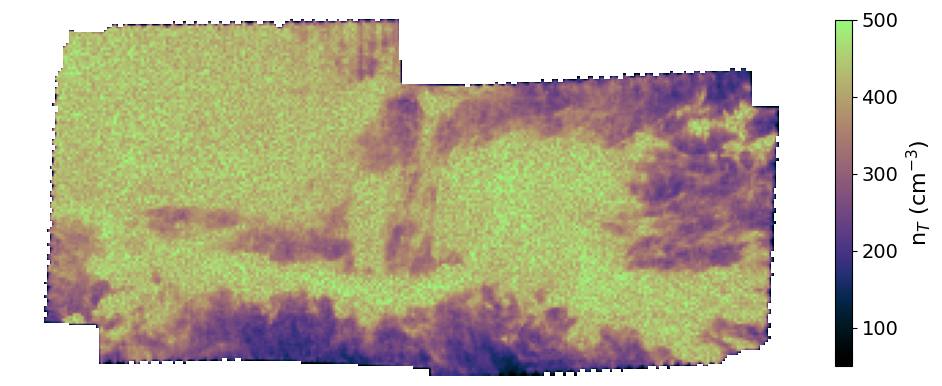

In [17]:
modelITurbDens_plot = modelITurbDens.copy()
modelITurbDens_plot[dataZoom <= 0] = np.nan

vmin, vmax = 5e1, 500

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

im1 = ax.imshow(modelITurbDens_plot, cmap=cmr.lilac, norm=colors.Normalize(vmin=vmin, vmax=vmax), origin='lower')
ax.axis(False)
ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label("n$_T$ (cm$^{-3}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

del modelITurbDens_plot

We change the plot style here slightly to better match Figure 5 of Xu+2023, ApJ, 950, 146, which used a Denoising Diffusuion Probabilistic Model (DDPM) to generate a characteristic density. In their model, they train against a mass-weighted density along the line of sight from simulations. From the paper presenting this method, we demonstrated that towards higher densities, the gravitational density is similar in value to the mass-weighted average.

The Xu+2023 DDPM model finds a peak number density within the filament of $4.7\times 10^4$ cm<sup>-3</sup>, which is similar to the previous results from Palmeirim+2013, which found $7.5\times 10^4$ cm<sup>-3</sup>,, and Li & Goldsmith (2012), using HC3N, of $3.6\times 10^4$ .cm<sup>-3</sup>. We estimate the mean and maximum filament density in just a part of the filament, denoted by the box and the contour.

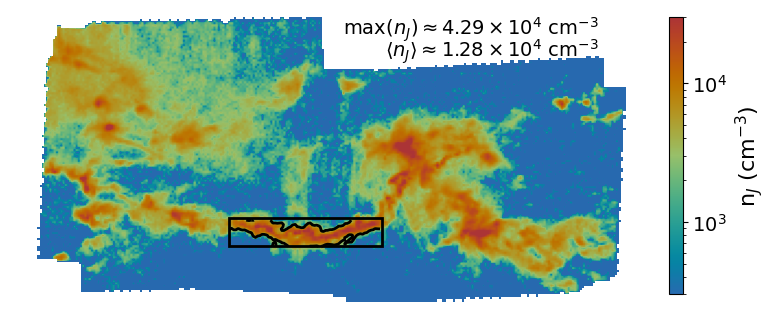

In [18]:
modelIGravDens_plot = modelIGravDens.copy()
modelIGravDens_plot[dataZoom <= 0] = np.nan

vmin, vmax = 3e2, 3e4

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

filPl = modelIGravDens_plot[25:38, 100:170].copy()
filPl[filPl < 4E3] = np.nan

# make a new array with modelIGravDens_plot where everything outside of the zoom area is set to nan
modelIGravDens_pl2 = np.zeros_like(modelIGravDens_plot)*np.nan
modelIGravDens_pl2[25:38, 100:170] = modelIGravDens_plot[25:38, 100:170]

im1 = ax.imshow(modelIGravDens_plot, cmap=cmr.get_sub_cmap('cmr.infinity', 0.2, 0.8), norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
# Add rectangle over the zoom in region
rect = mpl.patches.Rectangle((100, 25), 70, 13, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.contour(modelIGravDens_pl2, levels=[4E3], colors='k', linewidths=2)
ax.axis('off')

meanFil = np.nanmean(filPl)
strMean = "%.4e"%meanFil
pref = float(strMean[0:strMean.index('e')])
exp = int(strMean[strMean.index('e')+1:])
ax.annotate(r'$\langle n_J \rangle \approx %.2f\times 10^{%d}$ cm$^{-3}$'%(pref, exp), xy=(0.95, 0.905), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

maxFil = np.nanmax(filPl)
strMax = "%.4e"%maxFil
pref = float(strMax[0:strMax.index('e')])
exp = int(strMax[strMax.index('e')+1:])
ax.annotate(r'max$(n_J) \approx %.2f\times 10^{%d}$ cm$^{-3}$'%(pref, exp), xy=(0.95, 0.98), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label("n$_J$ (cm$^{-3}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)

plt.show()

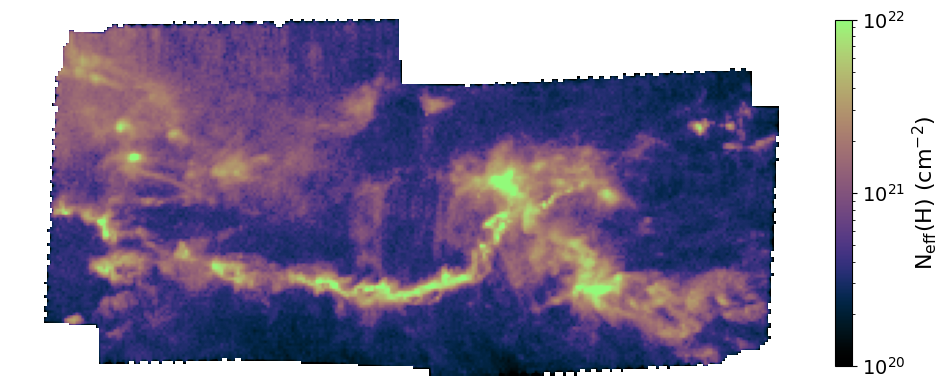

In [19]:
ModelI_Neff[dataZoom <= 0] = np.nan
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

vmin, vmax = 1e20, 1e22

im1 = ax.imshow(ModelI_Neff, cmap=cmr.lilac, norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
ax.axis(False)
ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label(r"N$_{\rm eff}$(H) (cm$^{-2}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

Since we break the line of sight into two components, we can visualize the contribution of each component to the total column density. Below, the ratio of the gravitational column to the total observed and the turbulent column to the total observed is shown. What is quickly evidence is that along diffuse lines of sight, nearly 100% is turbulent while in the dense filament and knots, it flips to nearly 100% gravitational. Having both components means analysis can be done for the turbulent envelope and the dense gas separately.

/var/folders/9z/5hqd6d4j4wl3_7tdgyftw0nm0000gp/T/ipykernel_62740/207328771.py:4: RuntimeWarning: invalid value encountered in divide
  im1 = ax.imshow(modelIGravCol/dataZoom, cmap='magma', norm=colors.Normalize(vmin=0.0, vmax=1), origin='lower')


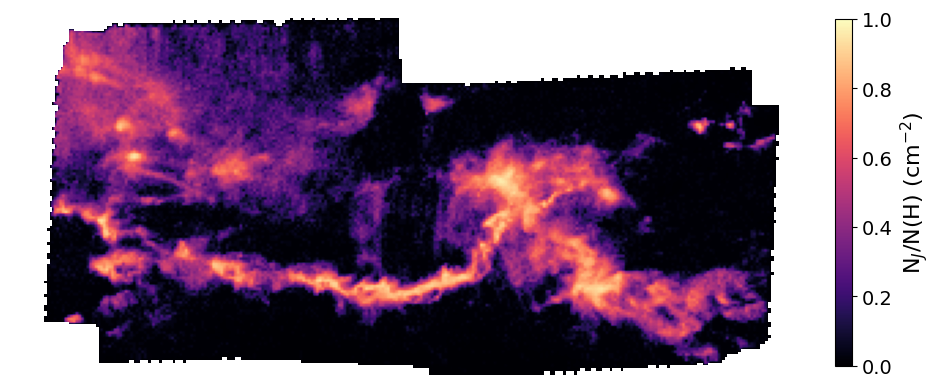

In [20]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

im1 = ax.imshow(modelIGravCol/dataZoom, cmap='magma', norm=colors.Normalize(vmin=0.0, vmax=1), origin='lower')
ax.axis(False)
ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label("N$_J$/N(H) (cm$^{-2}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)


plt.tight_layout()
plt.show()

/var/folders/9z/5hqd6d4j4wl3_7tdgyftw0nm0000gp/T/ipykernel_62740/3757457175.py:4: RuntimeWarning: invalid value encountered in divide
  im1 = ax.imshow(modelITurbCol/dataZoom, cmap='magma', norm=colors.Normalize(vmin=0.0, vmax=1), origin='lower')


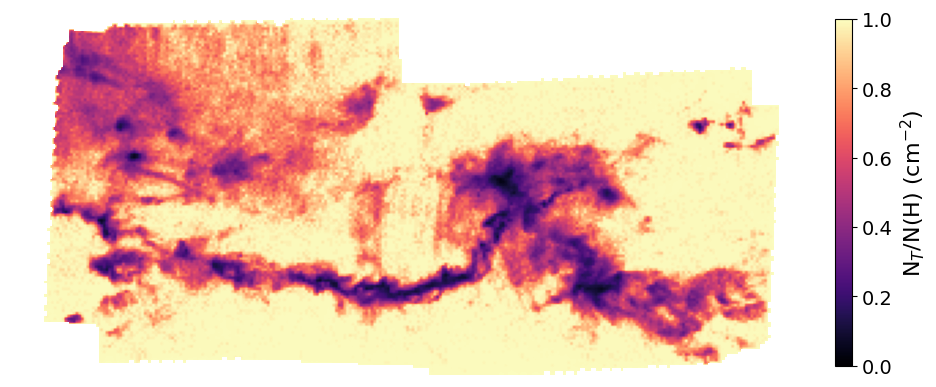

In [21]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

im1 = ax.imshow(modelITurbCol/dataZoom, cmap='magma', norm=colors.Normalize(vmin=0.0, vmax=1), origin='lower')
ax.axis(False)
ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label("N$_T$/N(H) (cm$^{-2}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)


plt.tight_layout()
plt.show()

### Example science case: free-fall time of the gas
Using the gravitational density, one can estimate the free-fall time of the dense gas across the entire cloud. Accordingly, we see that the filament has the shortest free-fall time, on average about 0.4 Myr, while the turbulent envelope has a free-fall time approaching 1 Myr. These values can be fed into empirical star formation models, for instance.

/Users/brandt/opt/anaconda3/envs/py38/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


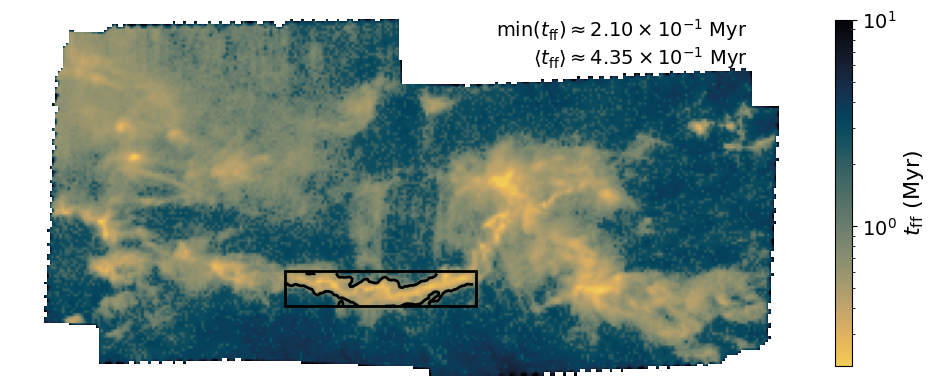

In [22]:
rhoGrav = ((modelIGravDens*u.cm**(-3))*mu*c.m_p).to(u.g*u.cm**(-3))
tff = np.sqrt((3.0*np.pi)/(32.0*c.G*rhoGrav)).decompose().to(u.Myr)
tff_plot = tff.copy().value
tff_plot[dataZoom <= 0] = np.nan

filPl = tff[25:38, 100:170].copy().value
filDens = modelIGravDens[25:38, 100:170].copy()
filPl[filDens < 4e3] = np.nan
mintff = np.nanmin(filPl)
meantff = np.nanmean(filPl)

vmin, vmax = mintff, 1e1

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

im1 = ax.imshow(tff_plot, cmap=cmr.get_sub_cmap('cmr.eclipse_r', 0.1, 0.95), norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
ax.axis('off')
ax.set_aspect('equal')
rect = mpl.patches.Rectangle((100, 25), 70, 13, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.contour(modelIGravDens_pl2, levels=[4E3], colors='k', linewidths=2)

strMean = "%.4e"%meantff
pref = float(strMean[0:strMean.index('e')])
exp = int(strMean[strMean.index('e')+1:])
ax.annotate(r'$\langle t_{\rm ff} \rangle \approx %.2f\times 10^{%d}$ Myr'%(pref, exp), xy=(0.95, 0.905), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

strMax = "%.4e"%mintff
pref = float(strMax[0:strMax.index('e')])
exp = int(strMax[strMax.index('e')+1:])
ax.annotate(r'min$(t_{\rm ff}) \approx %.2f\times 10^{%d}$ Myr'%(pref, exp), xy=(0.95, 0.98), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label(r"$t_{\rm ff}$ (Myr)", fontsize=16)
cb1.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

## Method II Plots

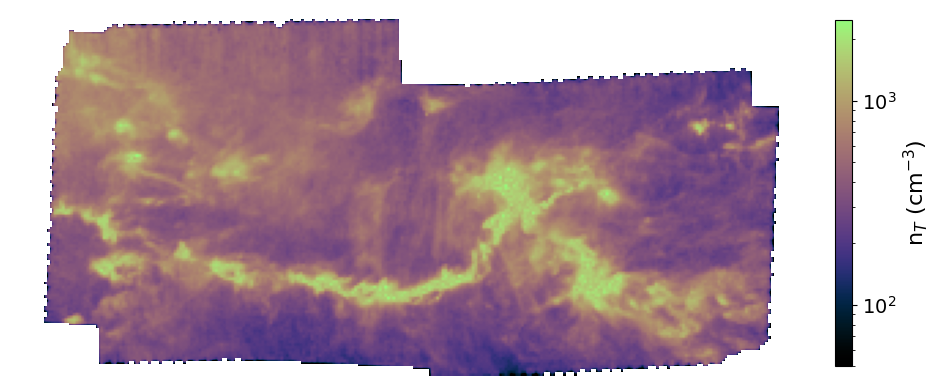

In [23]:

modelIITurbDens_plot = modelIITurbDens.copy()
modelIITurbDens_plot[modelIITurbDens_plot <= 0] = np.nan

vmin, vmax = 5e1, 2.5e3

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

im1 = ax.imshow(modelIITurbDens_plot, cmap=cmr.lilac, norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
ax.axis(False)
ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label("n$_T$ (cm$^{-3}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

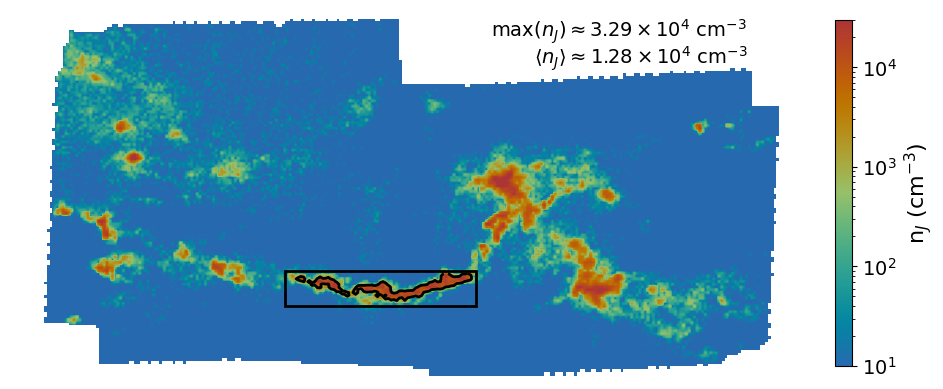

In [27]:
modelIIGravDens_plot = modelIIGravDens.copy()
modelIIGravDens_plot[dataZoom <= 0] = np.nan

vmin, vmax = 1e1, 3e4


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

filPl = modelIIGravDens_plot[25:38, 100:170].copy()
filPl[filPl < 4e3] = np.nan

# make a new array with modelIGravDens_plot where everything outside of the zoom area is set to nan
modelIIGravDens_pl2 = np.zeros_like(modelIIGravDens_plot)*np.nan
modelIIGravDens_pl2[25:38, 100:170] = modelIIGravDens_plot[25:38, 100:170]

im1 = ax.imshow(modelIIGravDens_plot, cmap=cmr.get_sub_cmap('cmr.infinity', 0.2, 0.8), norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
# Add rectangle over the zoom in region
rect = mpl.patches.Rectangle((100, 25), 70, 13, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.contour(modelIIGravDens_pl2, levels=[4E3], colors='k', linewidths=2)
ax.axis('off')

meanFil = np.nanmean(filPl)
strMean = "%.4e"%meanFil
pref = float(strMean[0:strMean.index('e')])
exp = int(strMean[strMean.index('e')+1:])
ax.annotate(r'$\langle n_J \rangle \approx %.2f\times 10^{%d}$ cm$^{-3}$'%(pref, exp), xy=(0.95, 0.905), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

maxFil = np.nanmax(filPl)
strMax = "%.4e"%maxFil
pref = float(strMax[0:strMax.index('e')])
exp = int(strMax[strMax.index('e')+1:])
ax.annotate(r'max$(n_J) \approx %.2f\times 10^{%d}$ cm$^{-3}$'%(pref, exp), xy=(0.95, 0.98), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

#ax.axis(False)
ax.set_aspect('equal')
cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label("n$_J$ (cm$^{-3}$)", fontsize=16)
cb1.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

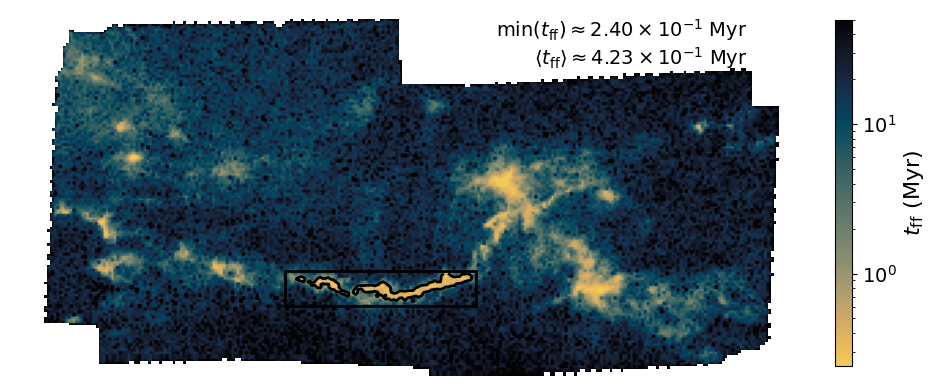

In [25]:
rhoGrav = ((modelIIGravDens*u.cm**(-3))*mu*c.m_p).to(u.g*u.cm**(-3))
tff = np.sqrt((3.0*np.pi)/(32.0*c.G*rhoGrav)).decompose().to(u.Myr)
tff_plot = tff.copy().value
tff_plot[dataZoom <= 0] = np.nan

filPl = tff[25:38, 100:170].copy().value
filDens = modelIIGravDens[25:38, 100:170].copy()
filPl[filDens < 4e3] = np.nan
mintff = np.nanmin(filPl)
meantff = np.nanmean(filPl)

vmin, vmax = mintff, 5e1

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

im1 = ax.imshow(tff_plot, cmap=cmr.get_sub_cmap('cmr.eclipse_r', 0.1, 0.95), norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
ax.axis('off')
ax.set_aspect('equal')
rect = mpl.patches.Rectangle((100, 25), 70, 13, linewidth=2, edgecolor='k', facecolor='none')
ax.add_patch(rect)
ax.contour(modelIIGravDens_pl2, levels=[4E3], colors='k', linewidths=2)

strMean = "%.4e"%meantff
pref = float(strMean[0:strMean.index('e')])
exp = int(strMean[strMean.index('e')+1:])
ax.annotate(r'$\langle t_{\rm ff} \rangle \approx %.2f\times 10^{%d}$ Myr'%(pref, exp), xy=(0.95, 0.905), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

strMax = "%.4e"%mintff
pref = float(strMax[0:strMax.index('e')])
exp = int(strMax[strMax.index('e')+1:])
ax.annotate(r'min$(t_{\rm ff}) \approx %.2f\times 10^{%d}$ Myr'%(pref, exp), xy=(0.95, 0.98), xycoords='axes fraction', fontsize=14, ha='right', va='top', color='k')

cb1 = fig.colorbar(im1, shrink=0.45)
cb1.set_label(r"$t_{\rm ff}$ (Myr)", fontsize=16)
cb1.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [26]:
## Save off data for the chemical model notebook
np.save("data/ModelIGravDens_taurus.npy", modelIGravDens)
np.save("data/ModelITurbDens_taurus.npy", modelITurbDens)
np.save("data/ModelINeff_taurus.npy", ModelI_Neff)
np.save("data/ModelITurbCol_taurus.npy", modelITurbCol)